In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
!cp './kaggle.json' '/root/.kaggle/'

In [4]:
!kaggle datasets download --force -d 'tongpython/cat-and-dog'
!rm '/root/.kaggle/kaggle.json'

 96% 209M/218M [00:02<00:00, 99.7MB/s]
100% 218M/218M [00:02<00:00, 81.0MB/s]


# Import các thư viện cần thiết

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [6]:
!unzip 'cat-and-dog.zip' -d 'my_data'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: my_data/training_set/training_set/cats/cat.3705.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3706.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3707.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3708.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3709.jpg  
  inflating: my_data/training_set/training_set/cats/cat.371.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3710.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3711.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3712.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3713.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3714.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3715.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3716.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3717.jpg  
  infl

In [ ]:
train_path = 'my_data/training_set/training_set'
# valid_path = 'data/dogs-vs-cats/valid'
test_path = 'my_data/test_set/test_set'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


1. `ImageDataGenerator.flow_from_directory ()` tạo ra `DirectoryIterator`, nơi tạo ra các lô dữ liệu hình ảnh chuẩn hóa từ các thư mục dữ liệu tương ứng.
2. Đối với ImageDataGenerator cho mỗi bộ dữ liệu, chỉ định `preprocessing_function=tf.keras.applications.vgg16.preprocess_input`. Có thể hiểu điều này là một bước xử lý bổ sung trên hình ảnh. Trình xử lý này làm việc với VGG16 CNN.
3. Đến `flow_from_directory()`, đầu tiên ta chỉ định đường dẫn cho dữ liệu, sau đó chỉ định `target_size` của hình ảnh, nơi sẽ thay đổi kích thước tất cả các hình ảnh theo kích thước được chỉ định. Kích thước được chỉ định ở đây được xác định bởi kích thước đầu vào mà mạng nơ ron mong đợi.
4. Tham số lớp mong đợi một danh sách chứa các tên lớp bên dưới và cuối cùng, chỉ định `batch_size`.
5. Chỉ định `shuffle = False` cho `test_batches`. Bởi vì, sau này khi vẽ kết quả đánh giá từ mô hình thành ma trận nhầm lẫn, ta sẽ cần có thể truy cập các nhãn không bị xáo trộn cho bộ thử nghiệm. Theo mặc định, các bộ dữ liệu được xáo trộn.
6. Lưu ý, trong trường hợp bạn không biết nhãn cho dữ liệu thử nghiệm, bạn sẽ cần sửa đổi biến `test_batches`. Cụ thể, thay đổi sẽ là đặt các tham số `class = none` và` class_mode = none` trong `Flow_from_directory ()`.



# Trực quan hóa dữ liệu
Bây giờ ta gọi `next(train_batches)` để tạo một loạt hình ảnh và nhãn từ tập huấn luyện. Lưu ý rằng kích thước của lô này được xác định bởi `batch_size` mà chúng ta đã đặt khi chúng ta tạo `train_batches`.



# Chuẩn bị Train Data

In [ ]:
imgs, labels = next(train_batches)

Sử dụng chức năng vẽ biểu đồ thu được từ `TensorFlow's documentation` để vẽ các hình ảnh được xử lý

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

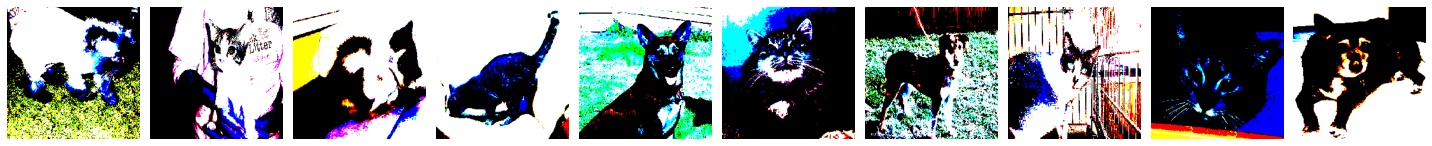

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [ ]:
plotImages(imgs)
print(labels)

Đây là những đợt ngẫu nhiên đầu tiên được xử lý từ tập huấn luyện trông như thế nào. Lưu ý rằng màu sắc dường như bị biến dạng. Điều này có liên quan đến việc xử lý VGG16 mà đã áp dụng cho các tập dữ liệu. Dữ liệu pixel RGB đã được xử lý theo cách mà dữ liệu hình ảnh bây giờ trông như thế này trước khi được truyền vào mạng.


Chó được biểu thị bằng mã hóa là `[0,1]` và mèo được biểu thị là `[1,0]`


Hiện tại, đã thiết lập để làm việc với dữ liệu này. Ta sẽ sử dụng dữ liệu này để đào tạo một CNN.

# Xây dựng CNN

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

Lớp đầu tiên trong mô hình là lớp chập 2 chiều. Lớp này sẽ có `32` bộ lọc đầu ra, mỗi bộ lọc có kích thước kernel là `3x3` và chúng tôi sẽ sử dụng chức năng kích hoạt `relu`.

Kích hoạt `zero-padding` bằng chỉ định `padding = 'same'`.

Bằng cách thêm một lớp chập khác với thông số kỹ thuật chính xác như lớp trước, ngoại trừ lớp `Conv2D` thứ hai này có 64 bộ lọc. Sự lựa chọn 64 ở đây một lần nữa là tùy ý, nhưng lựa chọn chung là có nhiều bộ lọc ở các lớp sau hơn các lớp trước là phổ biến. Lớp này một lần nữa được theo sau bởi cùng loại lớp `MaxPool2D`.

Sau đó, san phẳng đầu ra từ lớp chập và chuyển nó sang một `Dense layer`. `Dense layer` này là lớp đầu ra của mạng và do đó, nó có 2 nút, một cho mèo và một cho chó. Sử dụng chức năng kích hoạt `softmax` trên đầu ra của mình để đầu ra cho mỗi mẫu là phân phối xác suất so với đầu ra của chó và mèo.

Ta có thể kiểm tra tóm tắt của mô hình bằng cách gọi `model.summary()`.

# Train CNN

Đào tạo mô hình

Dùng hàm `model.fit()` để huấn luyện một mô hình.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

Bây giờ mô hình đã được xây dựng, mô hình được biên dịch bằng trình tối ưu hóa `Adam` với `learning rate` là `0,0001`, hàm mất nát là `categorical_cross_entropy`.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Bộ data có 2 lớp, định cấu hình lớp đầu ra của mình để chỉ có một đầu ra, ta có thể sử dụng cả `binary_crossentropy` và `categorical_crossentropy`. Cả hai đều hoạt động tốt như nhau và đạt được kết quả chính xác như nhau

Với `binary_crossentropy`, lớp cuối ta sẽ cần sử dụng `sigmoid`,thay vì `softmax`.

In [ ]:
model.fit(x=train_batches, epochs=20, verbose=2)

Epoch 1/20
801/801 - 39s - loss: 3.9702 - accuracy: 0.6312
Epoch 2/20
801/801 - 39s - loss: 0.3557 - accuracy: 0.8522
Epoch 3/20
801/801 - 38s - loss: 0.1215 - accuracy: 0.9618
Epoch 4/20
801/801 - 39s - loss: 0.0472 - accuracy: 0.9893
Epoch 5/20
801/801 - 38s - loss: 0.0346 - accuracy: 0.9920
Epoch 6/20
801/801 - 38s - loss: 0.0848 - accuracy: 0.9690
Epoch 7/20
801/801 - 39s - loss: 0.0669 - accuracy: 0.9764
Epoch 8/20
801/801 - 39s - loss: 0.0404 - accuracy: 0.9881
Epoch 9/20
801/801 - 43s - loss: 0.0355 - accuracy: 0.9874
Epoch 10/20
801/801 - 43s - loss: 0.0572 - accuracy: 0.9810
Epoch 11/20
801/801 - 41s - loss: 0.0330 - accuracy: 0.9891
Epoch 12/20
801/801 - 39s - loss: 0.0217 - accuracy: 0.9920
Epoch 13/20
801/801 - 38s - loss: 0.0214 - accuracy: 0.9928
Epoch 14/20
801/801 - 38s - loss: 0.0468 - accuracy: 0.9853
Epoch 15/20
801/801 - 38s - loss: 0.0211 - accuracy: 0.9925
Epoch 16/20
801/801 - 38s - loss: 0.0183 - accuracy: 0.9934
Epoch 17/20
801/801 - 38s - loss: 0.0309 - accura

Số epoch 20.

verbose = 2.

Hiệu suất của mô hình trên tập huấn luyện rất tốt, với độ chính xác đạt gần 100% và mất gần 0.

In [ ]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

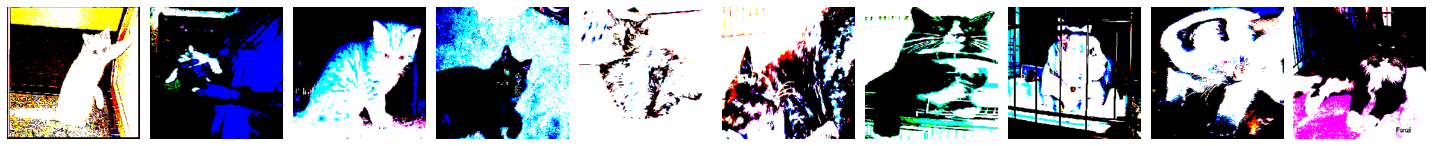

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
plotImages(test_imgs)
print(test_labels)

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Để có được hình dung rõ hơn về các kết quả này ta sẽ vẽ `confusion matrix`.

W`confusion matrix` sẽ được tào bằng `scikit-learn`.

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Đối với `confusion matrix`, ta nên chuyển các nhãn thực sự của bộ thử nghiệm, cùng với các nhãn dự đoán cho bộ thử nghiệm từ mô hình.

Để truy cập các nhãn thực sự mà không bị xáo trộn cho bộ kiểm tra bằng cách gọi là `test_batches.classes`.

Chuyển đổi các nhãn dự đoán được mã hóa thành định dạng giống như nhãn thực bằng cách chỉ chọn phần tử có giá trị cao nhất cho mỗi dự đoán bằng `np.argmax(predictions, axis=-1)`.

In [ ]:
cm

array([[804, 207],
       [428, 584]])

Sử dụng hàm `plot_confusion_matrix()` được sao chép trực tiếp từ `scikit-learn`

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Ta có thể kiểm tra `class_indices` cho các nhãn để chúng ta biết để chuyển chúng vào `confusion matrix`.

In [ ]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

Vẽ confusion matrix.

Confusion matrix, without normalization
[[804 207]
 [428 584]]


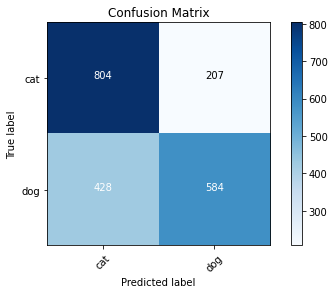

In [ ]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Từ ma trận ta có thể nhìn thấy có 804 con mèo và 584 con chó được gán nhãn đúng, và 207 con mèo và 428 con chó bị gán nhãn sai.

In [ ]:
no_classes = 100
no_epochs = 5
# optimizer = Adam()
verbosity = 1
num_folds = 5
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(imgs, labels):

  # Define the model architecture
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')])

  # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(x=train_batches, epochs=5, verbose=2)

  # Generate generalization metrics
    scores = model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
801/801 - 39s - loss: 3.1360 - accuracy: 0.6387
Epoch 2/5
801/801 - 39s - loss: 0.3178 - accuracy: 0.8686
Epoch 3/5
801/801 - 38s - loss: 0.1011 - accuracy: 0.9688
Epoch 4/5
801/801 - 38s - loss: 0.0500 - accuracy: 0.9881
Epoch 5/5
801/801 - 38s - loss: 0.0380 - accuracy: 0.9899
Score for fold 1: loss of 7.235488737933338e-05; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
801/801 - 38s - loss: 3.2296 - accuracy: 0.6356
Epoch 2/5
801/801 - 38s - loss: 0.3470 - accuracy: 0.8525
Epoch 3/5
801/801 - 39s - loss: 0.1163 - accuracy: 0.9651
Epoch 4/5
801/801 - 38s - loss: 0.0517 - accuracy: 0.9875
Epoch 5/5
801/801 - 38s - loss: 0.0456 - accuracy: 0.9871
Score for fold 2: loss of 0.005857178010046482; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 

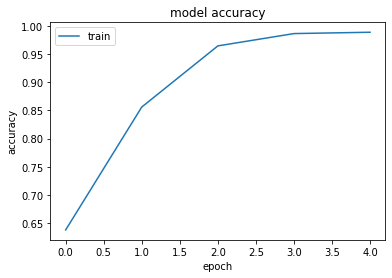

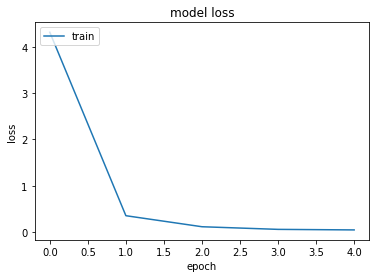

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Logistic Regression and ANN

In [12]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sns

from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dữ liệu


In [16]:
# Load at the data
data_test ='my_data/test_set/test_set/'
data_train ='my_data/training_set/training_set'

train_dogs = sorted(os.listdir(data_train +'/dogs'))
train_cats =  sorted(os.listdir(data_train +'/cats'))

test_dogs = sorted(os.listdir(data_test +'/dogs'))
test_cats =  sorted(os.listdir(data_test +'/cats'))

hiện thị 1 vài ảnh chỉ định từ dữ liệu

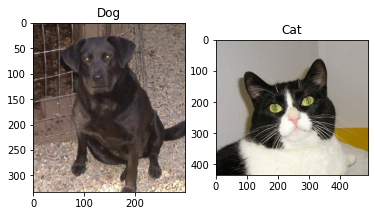

In [17]:
img_1 = implt.imread(data_train +'/dogs/dog.3851.jpg')
img_2 = implt.imread(data_train +'/cats/cat.3041.jpg')

plt.subplot(1, 2, 1)
plt.title('Dog')
plt.imshow(img_1)       
plt.subplot(1, 2, 2)
plt.title('Cat')
plt.imshow(img_2) 

# Xử lý dữ liệu
Bộ dữ liệu chứa hình ảnh màu RGB, ta sẽ chuyển đổi những hình ảnh này sang thang độ xám. Theo cách này, ta sẽ có thể xử lý với một chiều.

Thu nhỏ và tô màu cho hình ảnh bộ train

In [18]:
img_size = 64
dogs_images = []
cats_images = [] 
label = []

for i in train_dogs:
    if '.jpg' in i:
        if os.path.isfile(data_train +'/dogs/'+ i):
            images = Image.open(data_train +'/dogs/'+ i).convert('L') #converting grayscale         
            images = images.resize((img_size,img_size), Image.ANTIALIAS) #resizing to 64,64
            images = np.asarray(images)/255.0 #normalizing images
            dogs_images.append(images)  
            label.append(1) #label 1 for dogs
                    
for i in train_cats:
    if '.jpg' in i:
        if os.path.isfile(data_train+'/cats/'+ i):
            images = Image.open(data_train+'/cats/'+ i).convert('L')
            images = images.resize((img_size,img_size), Image.ANTIALIAS)
            images = np.asarray(images)/255.0 #normalizing images
            cats_images.append(images)  
            label.append(0) #label 0 for cats          
           
x_train = np.concatenate((dogs_images,cats_images),axis=0) # training dataset
x_train_label = np.asarray(label)# label array containing 0 and 1
x_train_label = x_train_label.reshape(x_train_label.shape[0],1)

print("dogs_images:",np.shape(dogs_images) , "cats_images:",np.shape(cats_images))
print("train_dataset:",np.shape(x_train), "train_values:",np.shape(x_train_label))


dogs_images: (4005, 64, 64) cats_images: (4000, 64, 64)
train_dataset: (8005, 64, 64) train_values: (8005, 1)


Thu nhỏ và tô màu các hình ảnh bộ test

In [19]:
img_size = 64
dogs_images = []
cats_images = [] 
label = []

for i in test_dogs:
    if '.jpg' in i:
        if os.path.isfile(data_test +'/dogs/'+ i):
            images = Image.open(data_test +'/dogs/'+ i).convert('L') #converting grayscale            
            images = images.resize((img_size,img_size), Image.ANTIALIAS) #resizing to 64,64
            images = np.asarray(images)/255.0 #normalizing images
            dogs_images.append(images)  
            label.append(1) #label 1 for dogs
 
for i in test_cats:
    if '.jpg' in i:
        if os.path.isfile(data_test +'/cats/'+ i):
            images = Image.open(data_test +'/cats/'+ i).convert('L')
            images = images.resize((img_size,img_size), Image.ANTIALIAS)
            images = np.asarray(images)/255.0 #normalizing images
            cats_images.append(images)  
            label.append(0) #label 0 for cats       
            
x_test = np.concatenate((dogs_images,cats_images),axis=0) # test dataset
x_test_label = np.asarray(label) # corresponding labels
x_test_label = x_test_label.reshape(x_test_label.shape[0],1)

print("dogs_images:",np.shape(dogs_images), "cats_images:",np.shape(cats_images))
print("test_dataset:",np.shape(x_test), "test_values:",np.shape(x_test_label))

dogs_images: (1012, 64, 64) cats_images: (1011, 64, 64)
test_dataset: (2023, 64, 64) test_values: (2023, 1)


Kết nối mảng, nhãn của train, test 

In [20]:
x = np.concatenate((x_train,x_test),axis=0) #train_data
y = np.concatenate((x_train_label,x_test_label),axis=0) #test data
x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) #flatten 3D image array to 2D
print("images:",x.shape, "labels:", y.shape)

images: (10028, 4096) labels: (10028, 1)


Chia dữ liệu thành dữ liệu đào tạo và kiểm tra. 20% dữ liệu sẽ là dữ liệu thử nghiệm.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = X_train.T
x_test = X_test.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 8022)
x test:  (4096, 2006)
y train:  (1, 8022)
y test:  (1, 2006)


# Logistic Regression không có sklearn

##Tóm tắt Logistic Regression
initialize_weights_and_bias: có giá trị ban đầu là weights và bias.

sigmoid: chức năng kích hoạt giới hạn đầu ra trong phạm vi từ 0 đến 1.

forward_backward propogation: được sử dụng để tính hàm chi phí (lỗi) và giảm độ dốc (để tìm hiểu trọng số và giá trị sai lệch phù hợp nhằm giảm thiểu lỗi).

update: cập nhật các tham số học tập 'w' và 'b' để tìm giá trị tốt nhất của chúng để đào tạo tốt hơn.

predict: sử dụng x_test làm đầu vào cho việc chuyển tiếp.




In [22]:
def initialize_weights_and_bias(dimension):
    w=np.full((dimension,1),0.01)   
    b=0.0
    return w,b
def sigmoid(z):
    y_head=1/(1+np.exp(-z))
    return y_head
def forward_backward_propagation(w,b,x_train,y_train):
    #forward propagation
    z=np.dot(w.T,x_train)+b
    y_head=sigmoid(z)
    loss= -y_train*np.log(y_head)- (1-y_train)*np.log(1-y_head)
    cost=(np.sum(loss))/x_train.shape[1]   #x_train.shape[1] is for scaling
    
    #backward propagation
    #x_train.shape[1] is for scaling
    derivative_weight=(np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias=np.sum(y_head-y_train)/x_train.shape[1]
    gradients={'derivative_weight':derivative_weight,'derivative_bias':derivative_bias}
    
    return cost,gradients
def update(w,b,x_train,y_train,learnig_rate,number_of_iteration):
    cost_list=[]
    cost_list2=[]
    index=[]
    
    #updating(learning) parametres is number_of_iteration times
    for i in range(number_of_iteration):
        #make fordward and backward propagation and find cost and gradients
        cost,gradients=forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        #update
        w=w-learnig_rate*gradients['derivative_weight']
        b=b-learnig_rate*gradients['derivative_bias']
        
        if i%50 == 0:
            cost_list2.append(cost)
            index.append(i)
            print('cost after iteration %i: %f:' %(i,cost))
    
    #we update(learn) parametres weights and bias
    parameters={'weight':w,'bias':b}
    plt.figure(figsize=(4,4))
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel('Number of iteration')
    plt.ylabel('Cost')
    plt.show()
    
    return parameters,gradients,cost_list
def predict(w,b,x_test):
    z=sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction=np.zeros((1,x_test.shape[1]))
    #We're making an estimate based on our condition.
    for i in range(z.shape[1]):
        if z[0,i]<=0.5:
            Y_prediction[0,i]=0
        else:
            Y_prediction[0,i]=1
    return Y_prediction

cost after iteration 0: nan:
cost after iteration 50: 0.685270:
cost after iteration 100: 0.682787:
cost after iteration 150: 0.680978:
cost after iteration 200: 0.679562:
cost after iteration 250: 0.678413:
cost after iteration 300: 0.677456:
cost after iteration 350: 0.676641:
cost after iteration 400: 0.675935:
cost after iteration 450: 0.675314:


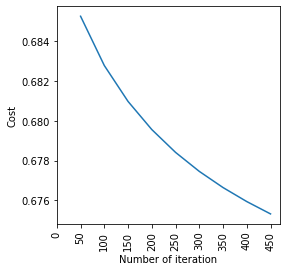

train accuracy: % 59.15
test accuracy: % 55.78


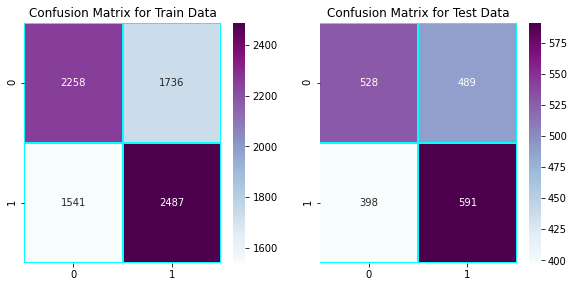

In [23]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # 4096
    w,b = initialize_weights_and_bias(dimension)
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    train_acc_lr = round((100 - np.mean(np.abs(y_prediction_train - y_train)) * 100),2)
    test_acc_lr = round((100 - np.mean(np.abs(y_prediction_test - y_test)) * 100),2)

    from sklearn.metrics import confusion_matrix
    cm_test = confusion_matrix(y_test.T, y_prediction_test.T)
    cm_train = confusion_matrix(y_train.T, y_prediction_train.T)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(3, 3, 1) # row, column, position
    ax1.set_title('Confusion Matrix for Train Data')

    ax2 = fig.add_subplot(3, 3, 2) # row, column, position
    ax2.set_title('Confusion Matrix for Test Data')
    
    sns.heatmap(data=cm_train,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax1, cmap='BuPu')
    sns.heatmap(data=cm_test,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax2, cmap='BuPu')  
    
    
    # Print train/test Errors
    print("train accuracy: %", train_acc_lr)
    print("test accuracy: %", test_acc_lr)
    return train_acc_lr, test_acc_lr
    

train_acc_lr, test_acc_lr = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.003, num_iterations = 500)

kết quả cho ta thấy accuracy của train là 59.15% và test là 55.78%

kết quả khá là thấp

Ta có thể điều chỉnh `learning_rate` và `num_iteration` để kiểm tra kết quả bị ảnh hưởng như thế nào.

#Logistic Regression với sklearn

train accuracy: 0.7364746945898778
test accuracy: 0.5314057826520439


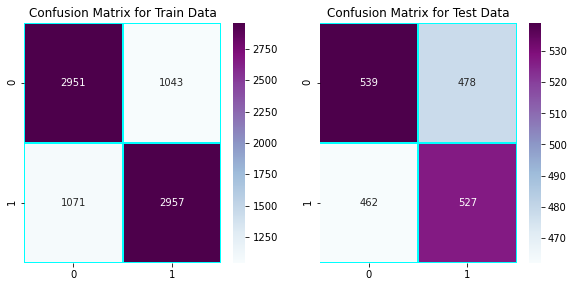

In [24]:
#Now we use sklearn libray 
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 0)
lr.fit(x_train.T,y_train.T)

y_pred_test=lr.predict(x_test.T)
y_pred_train=lr.predict(x_train.T)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test.T, y_pred_test)
cm_train = confusion_matrix(y_train.T, y_pred_train)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax1.set_title('Confusion Matrix for Train Data')

ax2 = fig.add_subplot(3, 3, 2) # row, column, position
ax2.set_title('Confusion Matrix for Test Data')

sns.heatmap(data=cm_train,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax1, cmap='BuPu')
sns.heatmap(data=cm_test,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax2, cmap='BuPu')  

print('train accuracy: {}'.format(lr.score(x_train.T,y_train.T)))
print('test accuracy: {}'.format(lr.score(x_test.T,y_test.T)))

kết quả khi sử dụng sklearn thì acc ở train lên đến 73.65% nhưng ở test vẫn khá thấp là 53.14% thấp hơn cả khi không sử dụng sklearn

# Artificial Neural Network (ANN)
![văn bản thay thế](https://i.stack.imgur.com/9jzpy.jpg)


##Layer Neural Network
Kích thước của các lớp và khởi tạo các tham số trọng số và độ lệch

Forward propagation

Hàm mất và hàm Chi phí (Loss function and Cost function)

Backward propagation

Cập nhật thông số

Dự đoán với trọng lượng tham số đã học và độ lệch

Tạo mô hình

In [25]:
# intialize parameters and layer sizes
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3,x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((3,1)),
                  "weight2": np.random.randn(y_train.shape[0],3) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

def forward_propagation_NN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

# Compute cost
def compute_cost_NN(A2, Y, parameters):
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):

    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: 0.408218
Cost after iteration 100: 0.368214
Cost after iteration 200: 0.354213
Cost after iteration 300: 0.348726
Cost after iteration 400: 0.346336


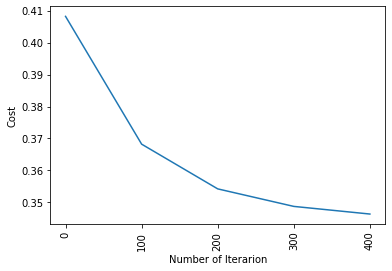

train accuracy: 51.047120418848166 %
test accuracy: 49.75074775672981 %


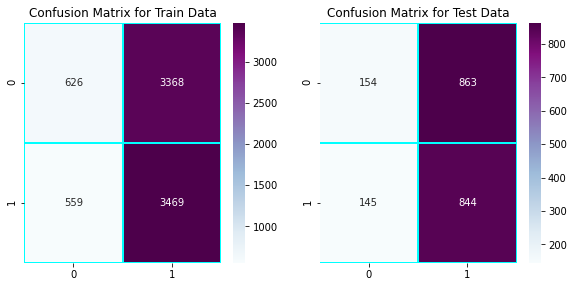

In [26]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)
    
    from sklearn.metrics import confusion_matrix
    cm_test = confusion_matrix(y_test.T, y_prediction_test.T)
    cm_train = confusion_matrix(y_train.T, y_prediction_train.T)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(3, 3, 1) # row, column, position
    ax1.set_title('Confusion Matrix for Train Data')

    ax2 = fig.add_subplot(3, 3, 2) # row, column, position
    ax2.set_title('Confusion Matrix for Test Data')
    
    sns.heatmap(data=cm_train,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax1, cmap='BuPu')
    sns.heatmap(data=cm_test,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax2, cmap='BuPu')  

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=500)

In [27]:
# reshaping
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

In [28]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units =32 , kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
    classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu')) 
    classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu')) 
    classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu')) 
    classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) 
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, epochs = 50)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Using TensorFlow backend.


Epoch 1/50
5348/5348 [==============================] - 3s 522us/step - loss: 0.6931 - accuracy: 0.4957
Epoch 2/50
5348/5348 [==============================] - 1s 188us/step - loss: 0.6834 - accuracy: 0.5585
Epoch 3/50
5348/5348 [==============================] - 1s 188us/step - loss: 0.6777 - accuracy: 0.5681
Epoch 4/50
5348/5348 [==============================] - 1s 186us/step - loss: 0.6759 - accuracy: 0.5724
Epoch 5/50
5348/5348 [==============================] - 1s 191us/step - loss: 0.6762 - accuracy: 0.5686
Epoch 6/50
5348/5348 [==============================] - 1s 191us/step - loss: 0.6690 - accuracy: 0.5840
Epoch 7/50
5348/5348 [==============================] - 1s 188us/step - loss: 0.6650 - accuracy: 0.6019
Epoch 8/50
5348/5348 [==============================] - 1s 188us/step - loss: 0.6674 - accuracy: 0.5942
Epoch 9/50
5348/5348 [==============================] - 1s 190us/step - loss: 0.6587 - accuracy: 0.6105
Epoch 10/50
5348/5348 [==============================] - 1s 186u

# KNN

In [7]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

print(neigh.predict([[1.1]]))

print(neigh.predict_proba([[0.9]]))

[0]
[[0.66666667 0.33333333]]


(280, 300, 3)


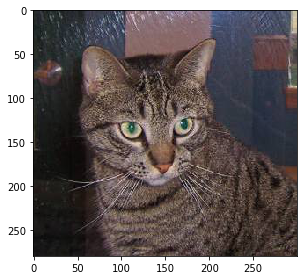

In [8]:
from skimage import io
cat1 = io.imread('my_data/training_set/training_set/cats/cat.1.jpg')
io.imshow(cat1)
print(cat1.shape)

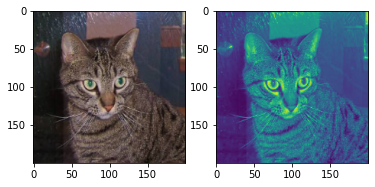

In [9]:
from skimage.transform import resize
cat1_ = resize(cat1, (200,200,3))
from skimage.color import rgb2gray
cat1_gs = rgb2gray(cat1_)

import matplotlib.pyplot as plt
fig=plt.figure()
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(cat1_)
fig.add_subplot(rows, columns, 2)
plt.imshow(cat1_gs)
plt.show()

Nhận 100 hình ảnh đầu tiên của chó và mèo để huấn luyện

In [15]:
x = []
y = []
for i in range(1,4001):
    cat = rgb2gray(resize(io.imread('my_data/training_set/training_set/cats/cat.{}.jpg'.format(i)), (200,200)))
    x.append(cat)
    y.append(0)

for i in range(1,4001):
    dog = rgb2gray(resize(io.imread('my_data/training_set/training_set/dogs/dog.{}.jpg'.format(i)), (200,200)))
    x.append(dog)
    y.append(1)

x, y = np.asarray(x), np.asarray(y) 
print('x shape: ', x.shape, 'y shape: ', y.shape)

x shape:  (8000, 200, 200) y shape:  (8000,)


In [16]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # phân loại hàng xóm gần nhất chỉ cần nhớ tất cả dữ liệu đào tạo
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        # tìm hình ảnh đào tạo gần nhất với hình ảnh thử nghiệm thứ i
        # sử dụng khoảng cách L1 (tổng chênh lệch giá trị tuyệt đối)
        distances = [np.sum(np.abs(self.Xtr[i] - X)) for i in range(0, len(self.Xtr))]
        #print(distances)
        min_indexs = np.argsort(distances)[:k]
        #print(min_indexs)
        y_ = self.ytr[min_indexs]
        #print(y_)
        counts = np.bincount(y_)
        #print(np.argmax(counts))
        return np.argmax(counts)

In [17]:
knn = NearestNeighbor()
knn.fit(x,y)
results_100 = []
for k in (1,2,3,5,10):
    print('k = ',k)
    for i in range(1,1001):
        results_100.append(knn.predict(rgb2gray(resize(io.imread('my_data/test_set/test_set/dogs/dog.{}.jpg'.format(4000+i)), (200,200))),5))
    unique, counts = np.unique(results_100, return_counts=True)
    print(dict(zip(unique, counts)))

k =  1
{0: 597, 1: 403}
k =  2
{0: 1194, 1: 806}
k =  3
{0: 1791, 1: 1209}
k =  5
{0: 2388, 1: 1612}
k =  10
{0: 2985, 1: 2015}


In [14]:
knn = NearestNeighbor()
knn.fit(x,y)
results_100 = []
for k in (1,2,3,5,10):
    print('k = ',k)
    for i in range(1,1001):
        results_100.append(knn.predict(rgb2gray(resize(io.imread('my_data/test_set/test_set/cats/cat.{}.jpg'.format(4000+i)), (200,200))),5))
    unique, counts = np.unique(results_100, return_counts=True)
    print(dict(zip(unique, counts)))

k =  1
{0: 503, 1: 497}
k =  2
{0: 1006, 1: 994}
k =  3
{0: 1509, 1: 1491}
k =  5
{0: 2012, 1: 1988}
k =  10
{0: 2515, 1: 2485}
